**Fraud Detection in Electricity and Gas Consumption Challenge**

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the aim of the challenge is to detect and recognize clients involved in fraudulent activities.

The solution will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.

About STEG (https://www.steg.com.tn/en/institutionnel/mission.html)

Challenge found on [ZINDI](https://zindi.africa/competitions/fraud-detection-in-electricity-and-gas-consumption-challenge)

The data provided by STEG is composed of two files. The first one is comprised of client data and the second one contains billing history from 2005 to 2019.

**Variable definitions**

**Client:**

Client_id: Unique id for client

District: District where the client is

Client_catg: Category client belongs to

Region: Area where the client is

Creation_date: Date client joined

Target: fraud:1 , not fraud: 0


**Invoice data**

Client_id: Unique id for the client

Invoice_date: Date of the invoice

Tarif_type: Type of tax

Counter_number:

Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect

Counter_code:

Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)

Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded

Consommation_level_1: Consumption_level_1

Consommation_level_2: Consumption_level_2

Consommation_level_3: Consumption_level_3

Consommation_level_4: Consumption_level_4

Old_index: Old index

New_index: New index

Months_number: Month number

Counter_type: Type of counter






**What Makes a Client Fall into the Fraud Category?**

Fraudulent clients (Target = 1) are identified based on abnormal energy consumption patterns and meter status issues. The key variables influencing fraud detection are:

1. Energy Consumption Variables (Most Important)
total_consumption: Summation of all four consumption levels.

* Sudden spikes in consumption might indicate tampering.

* Very low or zero consumption despite an active meter might indicate fraud.

* consumption_change = New_index - Old_index: Difference in meter readings.

* Negative or stagnant values could signal meter tampering.

* Unusual jumps in consumption might indicate bypassing meters.



2. Meter & Billing Issues
Counter_statue (Meter Status):

* If marked as “not working” or “on hold”, but there’s still energy usage, it may indicate fraud.

* Reading_remarque (Inspection Notes):If an inspector marks irregular readings, it could be a fraud flag.

* Counter_coefficient (Adjustment Factor):

* Higher coefficients indicate an unusual billing pattern.

3. Client and Location Variables
Client_catg (Client Category):

* Certain categories (e.g., industrial clients) may have higher fraud rates due to high consumption.

* Region / District: Some areas may have higher fraud prevalence.

**Most Important Variables for Fraud Prediction**

* Total Consumption (total_consumption)

* Consumption Change (consumption_change)

* Meter Status (Counter_statue)

* Inspection Notes (Reading_remarque, if available in dataset)

* Billing Adjustment (Counter_coefficient)

##Import Libraries

In [29]:
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

In [4]:
# Extracting data from zipfiles
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train")
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("test")


In [5]:
# Importing data from extracted zipfiles
train_clients = pd.read_csv("train/client_train.csv")
train_billing = pd.read_csv("train/invoice_train.csv")
test_clients = pd.read_csv("test/client_test.csv")
test_billing = pd.read_csv("test/invoice_test.csv")

/tmp/ipython-input-5-2379582734.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_billing = pd.read_csv("train/invoice_train.csv")


##Data Exploration

In [6]:
# Preview the data
print("Train Clients:", train_clients.shape)

print("Train Billing:", train_billing.shape)

Train Clients: (135493, 6)
Train Billing: (4476749, 16)


In [7]:
train_clients.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [8]:
train_billing.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [9]:
test_clients.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [10]:
test_billing.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


####Feature Engineering


In [11]:
#Aggregate billing features per client

# 1. Add derived features to billing data

#Adds up the values across all four consumption levels to get a single consumption_total per invoice.
train_billing['consumption_total'] = (
    train_billing[['consommation_level_1', 'consommation_level_2',
                   'consommation_level_3', 'consommation_level_4']].sum(axis=1)
)
#Computes the difference between the new_index and old_index — this approximates how much electricity was consumed since the last reading.
train_billing['consumption_delta'] = train_billing['new_index'] - train_billing['old_index']
#Normalizes total consumption by the number of months in that billing period (protects against dividing by 0 using replace(0, np.nan)).
train_billing['consumption_per_month'] = train_billing['consumption_total'] / train_billing['months_number'].replace(0, np.nan)


Preprocessing for Test Data

In [37]:
# 1. Add derived features to test billing data
test_billing['consumption_total'] = (
    test_billing[['consommation_level_1', 'consommation_level_2',
                  'consommation_level_3', 'consommation_level_4']].sum(axis=1)
)

test_billing['consumption_delta'] = test_billing['new_index'] - test_billing['old_index']

test_billing['consumption_per_month'] = test_billing['consumption_total'] / test_billing['months_number'].replace(0, np.nan)

# 2. Aggregate features at the client level
test_billing_agg = test_billing.groupby('client_id').agg({
    'consumption_total': ['sum', 'mean', 'std'],
    'consumption_delta': ['mean', 'std'],
    'months_number': ['mean'],
    'counter_code': 'nunique',
    'counter_statue': 'nunique',
    'reading_remarque': 'mean',
    'tarif_type': 'nunique',
    'counter_type': 'nunique',
    'invoice_date': 'count'
})

# Flatten multi-index columns
test_billing_agg.columns = ['_'.join(col).strip() for col in test_billing_agg.columns.values]

# Reset index to prepare for merge
test_billing_agg.reset_index(inplace=True)

# 3. Merge with client-level data
test_features = pd.merge(test_clients, test_billing_agg, how='left', on='client_id')

# 4. Handle missing values (clients with no billing history)
test_features.fillna(0, inplace=True)

The code below aims to group the billing records by client_id, and then computes aggregated statistics:

* sum, mean, std of consumption

* mean/std of consumption changes

* count of invoices

* number of unique meter statuses (counter_statue), tariff types, etc.

This transforms multiple rows per client into a single summarized row per client.

In [12]:
# 2. Aggregate features at the client level
billing_agg = train_billing.groupby('client_id').agg({
    'consumption_total': ['sum', 'mean', 'std'],
    'consumption_delta': ['mean', 'std'],
    'months_number': ['mean'],
    'counter_code': 'nunique',
    'counter_statue': 'nunique',
    'reading_remarque': 'mean',
    'tarif_type': 'nunique',
    'counter_type': 'nunique',
    'invoice_date': 'count'
})

#The aggregation above produces multi-level column names like ('consumption_total', 'sum'). This flattens them to strings like consumption_total_sum.
billing_agg.columns = ['_'.join(col).strip() for col in billing_agg.columns.values]

#Turns client_id from an index back into a normal column so we can merge later.
billing_agg.reset_index(inplace=True)


In [13]:
# Merge with client-level data
#Merges the newly engineered billing features into the original client dataframe.

client_features = pd.merge(train_clients, billing_agg, how='left', on='client_id')

# Handle missing values (e.g., clients with no billing history)
#If any clients had no invoice records, they’ll have missing values after the merge. This replaces all NaN values with 0 (a safe default).
client_features.fillna(0, inplace=True)

# Check result
client_features.head()

,disrict,client_id,client_catg,region,creation_date,target,consumption_total_sum,consumption_total_mean,consumption_total_std,consumption_delta_mean,consumption_delta_std,months_number_mean,counter_code_nunique,counter_statue_nunique,reading_remarque_mean,tarif_type_nunique,counter_type_nunique,invoice_date_count
0,60,train_Client_0,11,101,31/12/1994,0.0,12704,362.971429,341.553930,362.971429,341.553930,4.628571,2,1,6.971429,1,1,35
1,69,train_Client_1,11,107,29/05/2002,0.0,20629,557.540541,197.935960,557.540541,197.935960,4.324324,1,1,7.216216,1,1,37
2,62,train_Client_10,11,301,13/03/1986,0.0,15057,836.500000,646.808386,836.500000,646.808386,6.444444,2,1,7.055556,1,1,18
3,69,train_Client_100,11,105,11/07/1996,0.0,24,1.200000,3.607011,1.200000,3.607011,4.200000,1,1,6.150000,1,1,20
4,62,train_Client_1000,11,303,14/10/2014,0.0,12917,922.642857,633.485669,922.642857,633.485669,3.714286,1,1,8.857143,1,1,14


####Setting Features and Targets

In [14]:
# Separate features and target
X = client_features.drop(columns=['client_id', 'target', 'creation_date'])
y = client_features['target']


####Data Encoding

In [15]:
# Encode categorical columns (if any)
X = pd.get_dummies(X, drop_first=True)

###Preparing Training, and Validation Data

In [16]:
# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

####Checking for Imbalanced Data

Class Distribution:
 target
0.0    127927
1.0      7566
Name: count, dtype: int64

Percentage Distribution:
 target
0.0    94.415948
1.0     5.584052
Name: count, dtype: float64


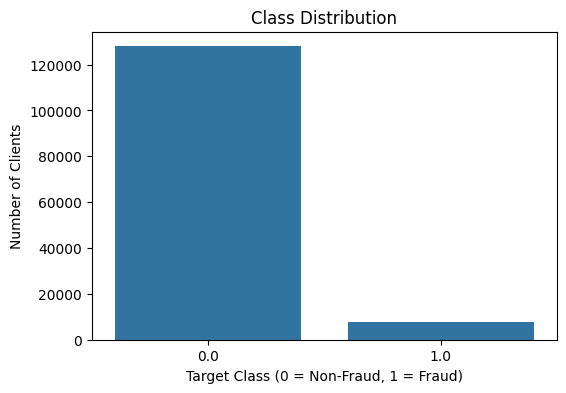

In [17]:
# Count class occurrences
class_counts = client_features['target'].value_counts()
print("Class Distribution:\n", class_counts)

# Calculate class percentages
print("\nPercentage Distribution:\n", class_counts / class_counts.sum() * 100)

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("Class Distribution")
plt.xlabel("Target Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Number of Clients")
plt.show()

####Handling Imbalanced Data

In [18]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

####Standardization

In [19]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)

###Model Training

#####Logistic Regression

In [20]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)
log_preds = logreg.predict(X_val_scaled)
log_proba = logreg.predict_proba(X_val_scaled)[:, 1]

#####Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_preds = rf.predict(X_val)
rf_proba = rf.predict_proba(X_val)[:, 1]

#####XGBoost

In [22]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=10, random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)
xgb_preds = xgb.predict(X_val)
xgb_proba = xgb.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#####LGBMClassifier

In [23]:
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
lgbm.fit(X_train_resampled, y_train_resampled)
lgbm_preds = lgbm.predict(X_val)
lgbm_proba = lgbm.predict_proba(X_val)[:, 1]

[LightGBM] [Info] Number of positive: 102341, number of negative: 102341
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 204682, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


####Model Evaluation

In [24]:
#Evaluation Function
def evaluate_model(name, y_true, y_pred, y_score):
    print(f"📊 {name} Evaluation")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_score))
    print("-" * 50)

In [25]:
evaluate_model("Logistic Regression", y_val, log_preds, log_proba)
evaluate_model("Random Forest", y_val, rf_preds, rf_proba)
evaluate_model("XGBoost", y_val, xgb_preds, xgb_proba)
evaluate_model("LightGBM", y_val, lgbm_preds, lgbm_proba)

📊 Logistic Regression Evaluation
Confusion Matrix:
[[17188  8398]
 [  622   891]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79     25586
         1.0       0.10      0.59      0.16      1513

    accuracy                           0.67     27099
   macro avg       0.53      0.63      0.48     27099
weighted avg       0.92      0.67      0.76     27099

ROC AUC Score: 0.6859679437836982
--------------------------------------------------
📊 Random Forest Evaluation
Confusion Matrix:
[[24070  1516]
 [ 1234   279]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     25586
         1.0       0.16      0.18      0.17      1513

    accuracy                           0.90     27099
   macro avg       0.55      0.56      0.56     27099
weighted avg       0.91      0.90      0.90     27099

ROC AUC Score: 0.7362463124119483
---------------------

Business goal: Detect as many fraudulent clients as possible to reduce financial losses for STEG.

 Missing a fraud (False Negative) is more costly than wrongly flagging an honest customer (False Positive).

That means:

Recall for class 1 (fraud) is the most important metric.

False positives can be tolerated, especially if they trigger a manual review.

**XGBoost flags the most fraud cases — ideal when the business goal is to recover maximum loss, even if false positives increase.**

| Model             | Recall (Fraud) | Precision (Fraud) | F1 (Fraud) | ROC AUC   | Comment                                           |
| ----------------- | -------------- | ----------------- | ---------- | --------- | ------------------------------------------------- |
| **Logistic**      | 0.59           | 0.10              | 0.16       | 0.686     | High recall, low precision. Many false positives. |
| **Random Forest** | 0.18           | 0.16              | 0.17       | **0.736** | Good balance, best AUC. Decent accuracy too.      |
| **XGBoost**       | **0.77**       | 0.09              | 0.16       | 0.713     | Highest recall, but at huge cost to precision.    |
| **LightGBM**      | 0.34           | 0.14              | 0.19       | 0.729     | Better balance than XGB, lower recall.            |


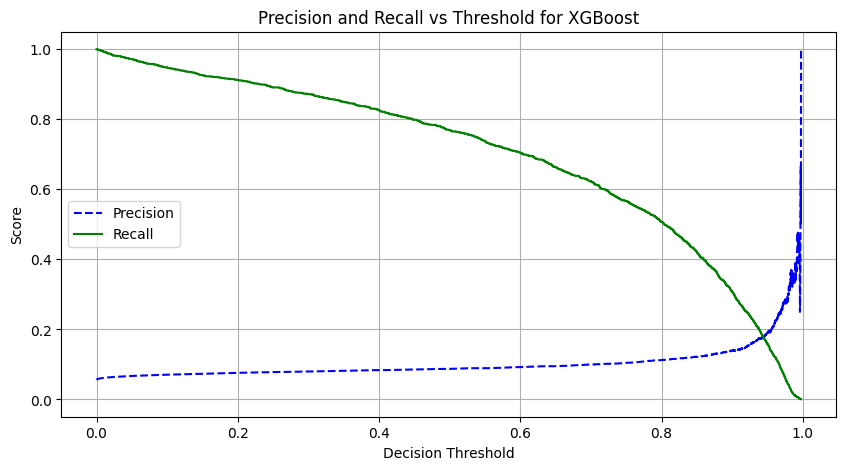

In [30]:
# Get predicted probabilities from XGBoost
y_scores = xgb.predict_proba(X_val)[:, 1]  # probability of class 1 (fraud)

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

#  Plot precision-recall vs. threshold

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold for XGBoost')
plt.legend()
plt.grid(True)
plt.show()


Based on the graph above, 0.9 was selected as the best decision threshold.

In [32]:
# Pick a threshold (you can try different values)
custom_threshold = 0.9

# Apply the new threshold
xgb_preds_custom = (y_scores >= custom_threshold).astype(int)

# Re-evaluate the model
evaluate_model(f"XGBoost (threshold = {custom_threshold})", y_val, xgb_preds_custom, y_scores)

📊 XGBoost (threshold = 0.9) Evaluation
Confusion Matrix:
[[22722  2864]
 [ 1048   465]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     25586
         1.0       0.14      0.31      0.19      1513

    accuracy                           0.86     27099
   macro avg       0.55      0.60      0.56     27099
weighted avg       0.91      0.86      0.88     27099

ROC AUC Score: 0.7126851169072808
--------------------------------------------------


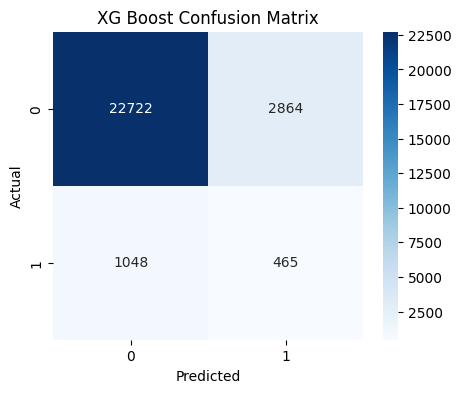

In [35]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_val, xgb_preds_custom), annot=True, fmt="d", cmap="Blues")
plt.title("XG Boost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

####Best Model - Generate Predictions based on Test Data

In [38]:
# Save client_id for submission
test_ids = test_features['client_id']

# Drop unused columns to match training features
X_test_final = test_features.drop(columns=['client_id', 'creation_date'])

In [41]:
# Predict with trained model (e.g., xgb)
test_probs = xgb.predict_proba(X_test_final)[:, 1]
test_preds = (test_probs >= 0.9).astype(int)  # used tuned threshold

In [43]:
# Create submission file
submission = pd.DataFrame({
    'client_id': test_ids,
    'target': test_preds
})

submission.to_csv('final_submission.csv', index=False)
print("Submission file saved as final_submission.csv")

Submission file saved as final_submission.csv
